In [1]:
from pylab import *
import numpy as np
import nylib, nylib2
import pandas as pd
import nibabel as nib
import UF_7T_animal_processing as syngap

In [2]:
# dataPath = '/data/Lafora_glycogen/Lafora_mice/20230906_140247_GAA_KO_DoB20230224_20230906_1_1/'
dataPath = '/data/UF/Jan_2024_data/20240117/20240117_093628_RH0433_glycoNOE_1_1'
mouse_id = 'RH0433'
savePath = '%s/../../processed_data/%s'%(dataPath, mouse_id)

from pathlib import Path
Path("%s"%(savePath)).mkdir(parents=True, exist_ok=True)

In [3]:
import datetime
import time
expNumbers = range(1, 100)
expMethod = [None for ii in range(len(expNumbers))]
expRunTime = [None for ii in range(len(expNumbers))]
Comments = [None for ii in range(len(expNumbers))]

for ii, ei in enumerate(expNumbers):
    try:
        expMethod[ii] = nylib.BrukerPar('%s/%s'%(dataPath, ei), 'method', 'Method=')[:-1]        
        timeTemp0 = ((nylib.searchFile('%s/%s/acqp'%(dataPath, ei), b'2024' )).split()[1:3])
        timeTemp1 = str(b' '.join(timeTemp0))
        timeTemp2 = time.strptime(timeTemp1,"b'%Y-%m-%d %H:%M:%S.%f'")
        timeTemp3 = datetime.datetime.fromtimestamp(time.mktime(timeTemp2))
        expRunTime[ii] = timeTemp3.strftime('%Y-%m-%d, %H:%M:%S')
        Comments[ii] = nylib.searchFileNext('%s/%s/pdata/1/visu_pars'%(dataPath, ei), 'VisuSeriesComment=')
            
    except:
        pass
expTable = zip(expNumbers, expMethod, expRunTime, Comments)
df = pd.DataFrame(data = expTable, columns=['ExperimentNumber', 'Method', 'expRunTime','Comment'])
df['expRunTime'] = (pd.to_datetime(df['expRunTime']))
# df['expRunTime'] = df['expRunTime'].dt.time
df.sort_values(by=['expRunTime'])
df = df[df.Method.notnull()]
df

,ExperimentNumber,Method,expRunTime,Comment
0,1,<Bruker:FLASH>,2024-01-17 10:06:15,None
1,2,<Bruker:RARE>,2024-01-17 10:20:32,None
2,3,<Bruker:FieldMap>,2024-01-17 10:12:05,None
4,5,<Bruker:RARE>,2024-01-17 10:24:18,None
5,6,<Bruker:RAREst>,2024-01-17 10:59:54,None
6,7,<Bruker:RARE>,2024-01-17 11:01:23,None
7,8,<Bruker:MSME>,2024-01-17 11:04:23,None
8,9,<Bruker:RAREVTR>,2024-01-17 11:07:27,None
9,10,<Bruker:RAREst>,2024-01-17 11:38:34,None


In [4]:
cest_folder = 6
T1_folder = 9
T2_folder = 8
HD_folder = 7

In [5]:
cest_freq, cest_data_raw = syngap.load_cest_data('%s/%d'%(dataPath, cest_folder))
data_HD = nylib.Paravision2dseqNew('%s/%d'%(dataPath, HD_folder))

(1, 1, 1, 256, 256)


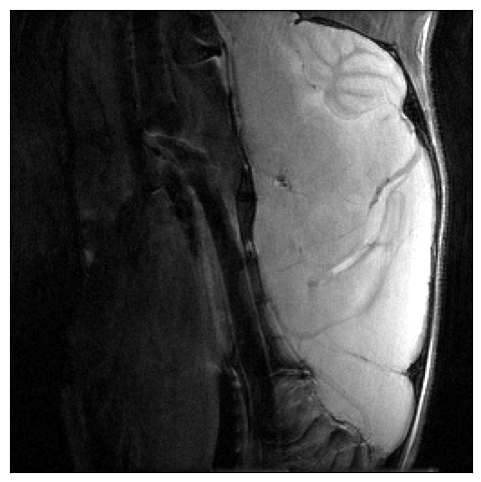

In [6]:
import cjlib
figure(figsize=(6,6))
cjlib.mimage(data_HD)
gray()
savefig('%s/HD_image.png'%(savePath), bbox_inches='tight')

Ir = transpose(data_HD)
Ir.shape

ni_img = nib.Nifti1Image(Ir, affine=np.eye(4))
nib.save(ni_img, "%s/HD_image.nii"%(savePath))

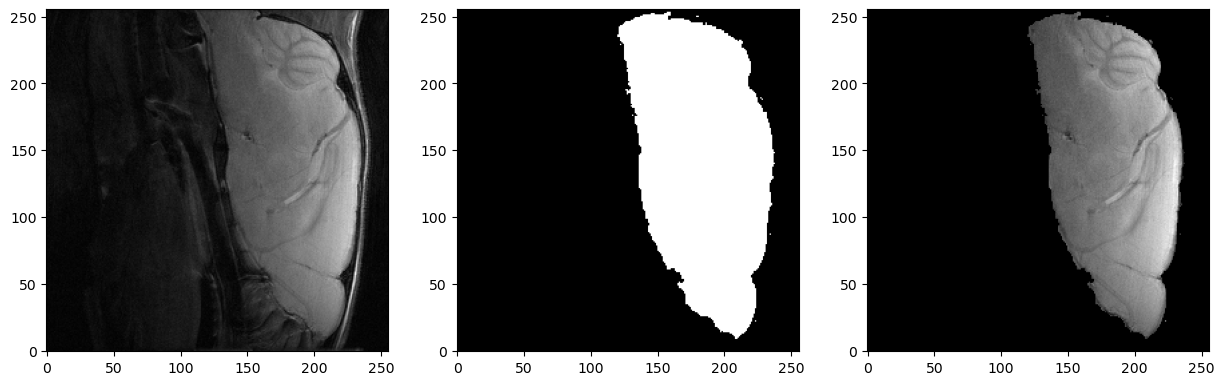

In [7]:
import atlasMorph as am
import nrrd

data2, header = nrrd.read('%s/%sSegmentation.seg.nrrd'%(savePath, mouse_id))
mask_HD = np.transpose(data2)[0]
skull_stripped = am.binSeg(data_HD, mask_HD)

fig, ax = plt.subplots(1,3, figsize = (15,15))
ax[0].imshow(data_HD, origin = 'lower')
ax[1].imshow(mask_HD, origin='lower')
ax[2].imshow(skull_stripped, origin = 'lower')

In [8]:
## Generate WASSR maps across the brain
import scipy
mask_cest = scipy.ndimage.zoom(mask_HD, (cest_data_raw.shape[-2]/data_HD.shape[-2], cest_data_raw.shape[-1]/data_HD.shape[-1]))
wassr_fit = syngap.lor_line_width(cest_freq, cest_data_raw, mask_cest)

In [9]:
np.squeeze(cest_data_raw).shape

(113, 64, 64)

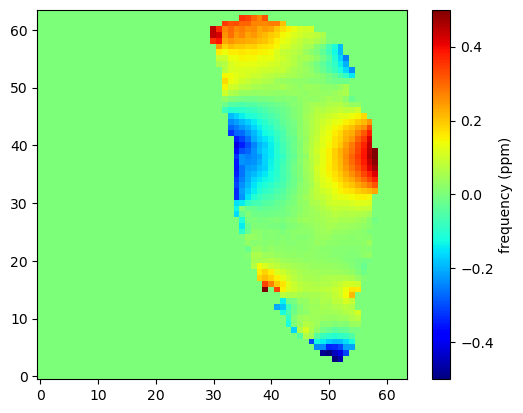

In [10]:
imshow(wassr_fit[1]/500., origin='lower')
clim(-0.5,0.5)
jet()
cbar = colorbar()
cbar.set_label('frequency (ppm)')
savefig('%s/wassr_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

In [11]:
# # nornmalize and then B0 correct data
cest_freq_norm, cest_data_corrected = syngap.correctedData(cest_freq, cest_data_raw, mask_cest, wassr_fit[1]/500.)
# save data
np.save('%s/cest_data_corrected_s%s.npy'%(savePath, mouse_id), cest_data_corrected)
np.save('%s/cest_freq_norm_s%s.npy'%(savePath, mouse_id), cest_freq_norm)

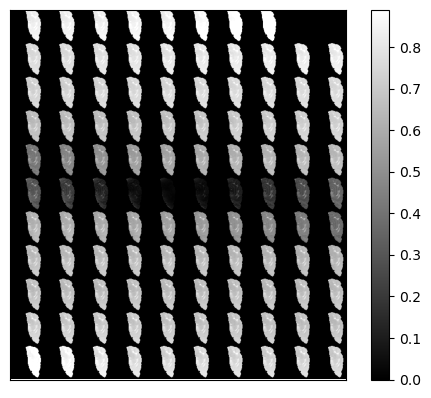

In [12]:
import cjlib
cjlib.mmontage(cest_data_corrected)
colorbar()
savefig('%s/corrected_cest_images_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

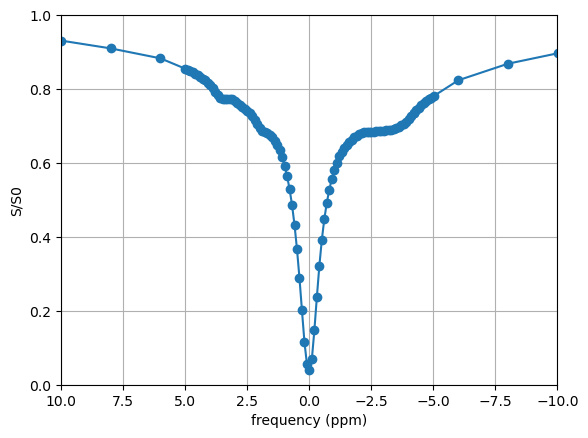

In [13]:
# get Z-spectra from across brain
brain_ints = nylib2.applyMask(cest_data_corrected, mask_cest)
plot(cest_freq_norm, brain_ints, 'o-')
xlim(10,-10)
ylim(0.0, 1.)
grid('on')
xlabel('frequency (ppm)')
ylabel('S/S0')
savefig('%s/z_spectra_brain_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

In [14]:
# Map T1, T2 and save
from brukerapi.dataset import Dataset
from scipy import ndimage
data_T1 = np.squeeze(np.transpose((Dataset('%s/%s/pdata/1/'%(dataPath, T1_folder))).data))
t = nylib.BrukerPar('%s/%d'%(dataPath, T1_folder), 'method', 'MultiRepTime=')

data_T2 = np.squeeze(np.transpose((Dataset('%s/%s/pdata/1/'%(dataPath, T2_folder))).data))
t2_delays = nylib.BrukerPar('%s/%d'%(dataPath, T2_folder), 'method', 'EffectiveTE=')
data_T2 = data_T2[1:]
t2_delays = t2_delays[1:]

T1_map = zeros((mask_cest.shape))
T2_map = zeros((mask_cest.shape))
for ix in range(T1_map.shape[0]):
    for iy in range(T1_map.shape[1]):
        if (mask_cest[ix, iy] != 0):
            T1 = data_T1[:,ix, iy]
            T1_map[ix, iy] = syngap.T1fit(t, T1)/1000
            if T1_map[ix, iy] < 1.:
                T1 = ndimage.median_filter(data_T1[:,ix, iy], size = 5)
                T1_map[ix, iy] = syngap.T1fit(t, T1)/1000
            T2 = data_T2[:,ix, iy]
            T2_map[ix, iy] = syngap.T2fit(t2_delays, T2)

np.save('%s/t1_map_s%s.npy'%(savePath, mouse_id), T1_map)
np.save('%s/t2_map_s%s.npy'%(savePath, mouse_id), T2_map)

/home/yadav_lab/python_libs/UF_7T_animal_processing.py:96: RuntimeWarning: overflow encountered in exp
  x[k] = p0[0]*(1-np.exp(-i/p0[1]))
/home/yadav_lab/python_libs/UF_7T_animal_processing.py:96: RuntimeWarning: overflow encountered in scalar multiply
  x[k] = p0[0]*(1-np.exp(-i/p0[1]))


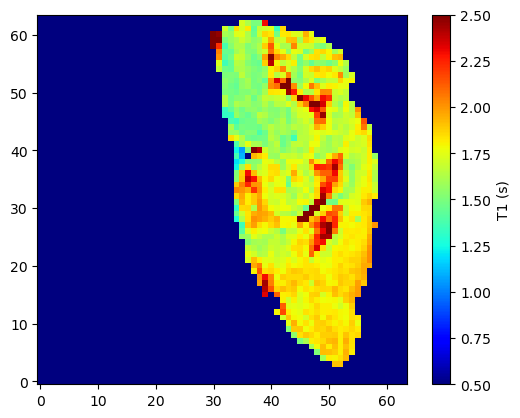

In [15]:
imshow(T1_map, origin='lower')
jet()
clim(0.5, 2.5)
cbar = colorbar()
cbar.set_label('T1 (s)')
savefig('%s/T1_map_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

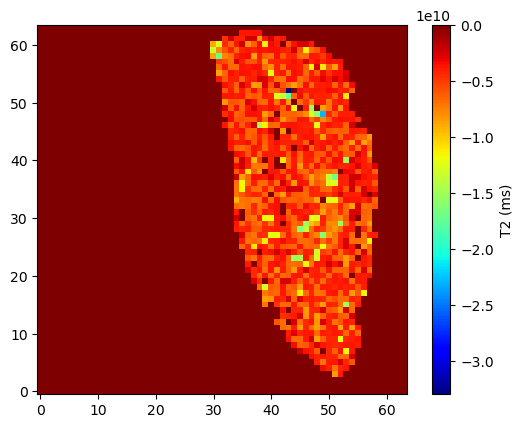

In [16]:
imshow(T2_map, origin='lower')
jet()
#clim(20, 70)
cbar = colorbar()
cbar.set_label('T2 (ms)')
savefig('%s/T2_map_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

/home/yadav_lab/python_libs/PLOF_fitting_voigt_peak_linear_back.py:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0, 2, 4, 6, 8], fontsize= 25)


peak amplitude: 0.022
peak position: 3.603
peak width: 0.531
R: 0.095


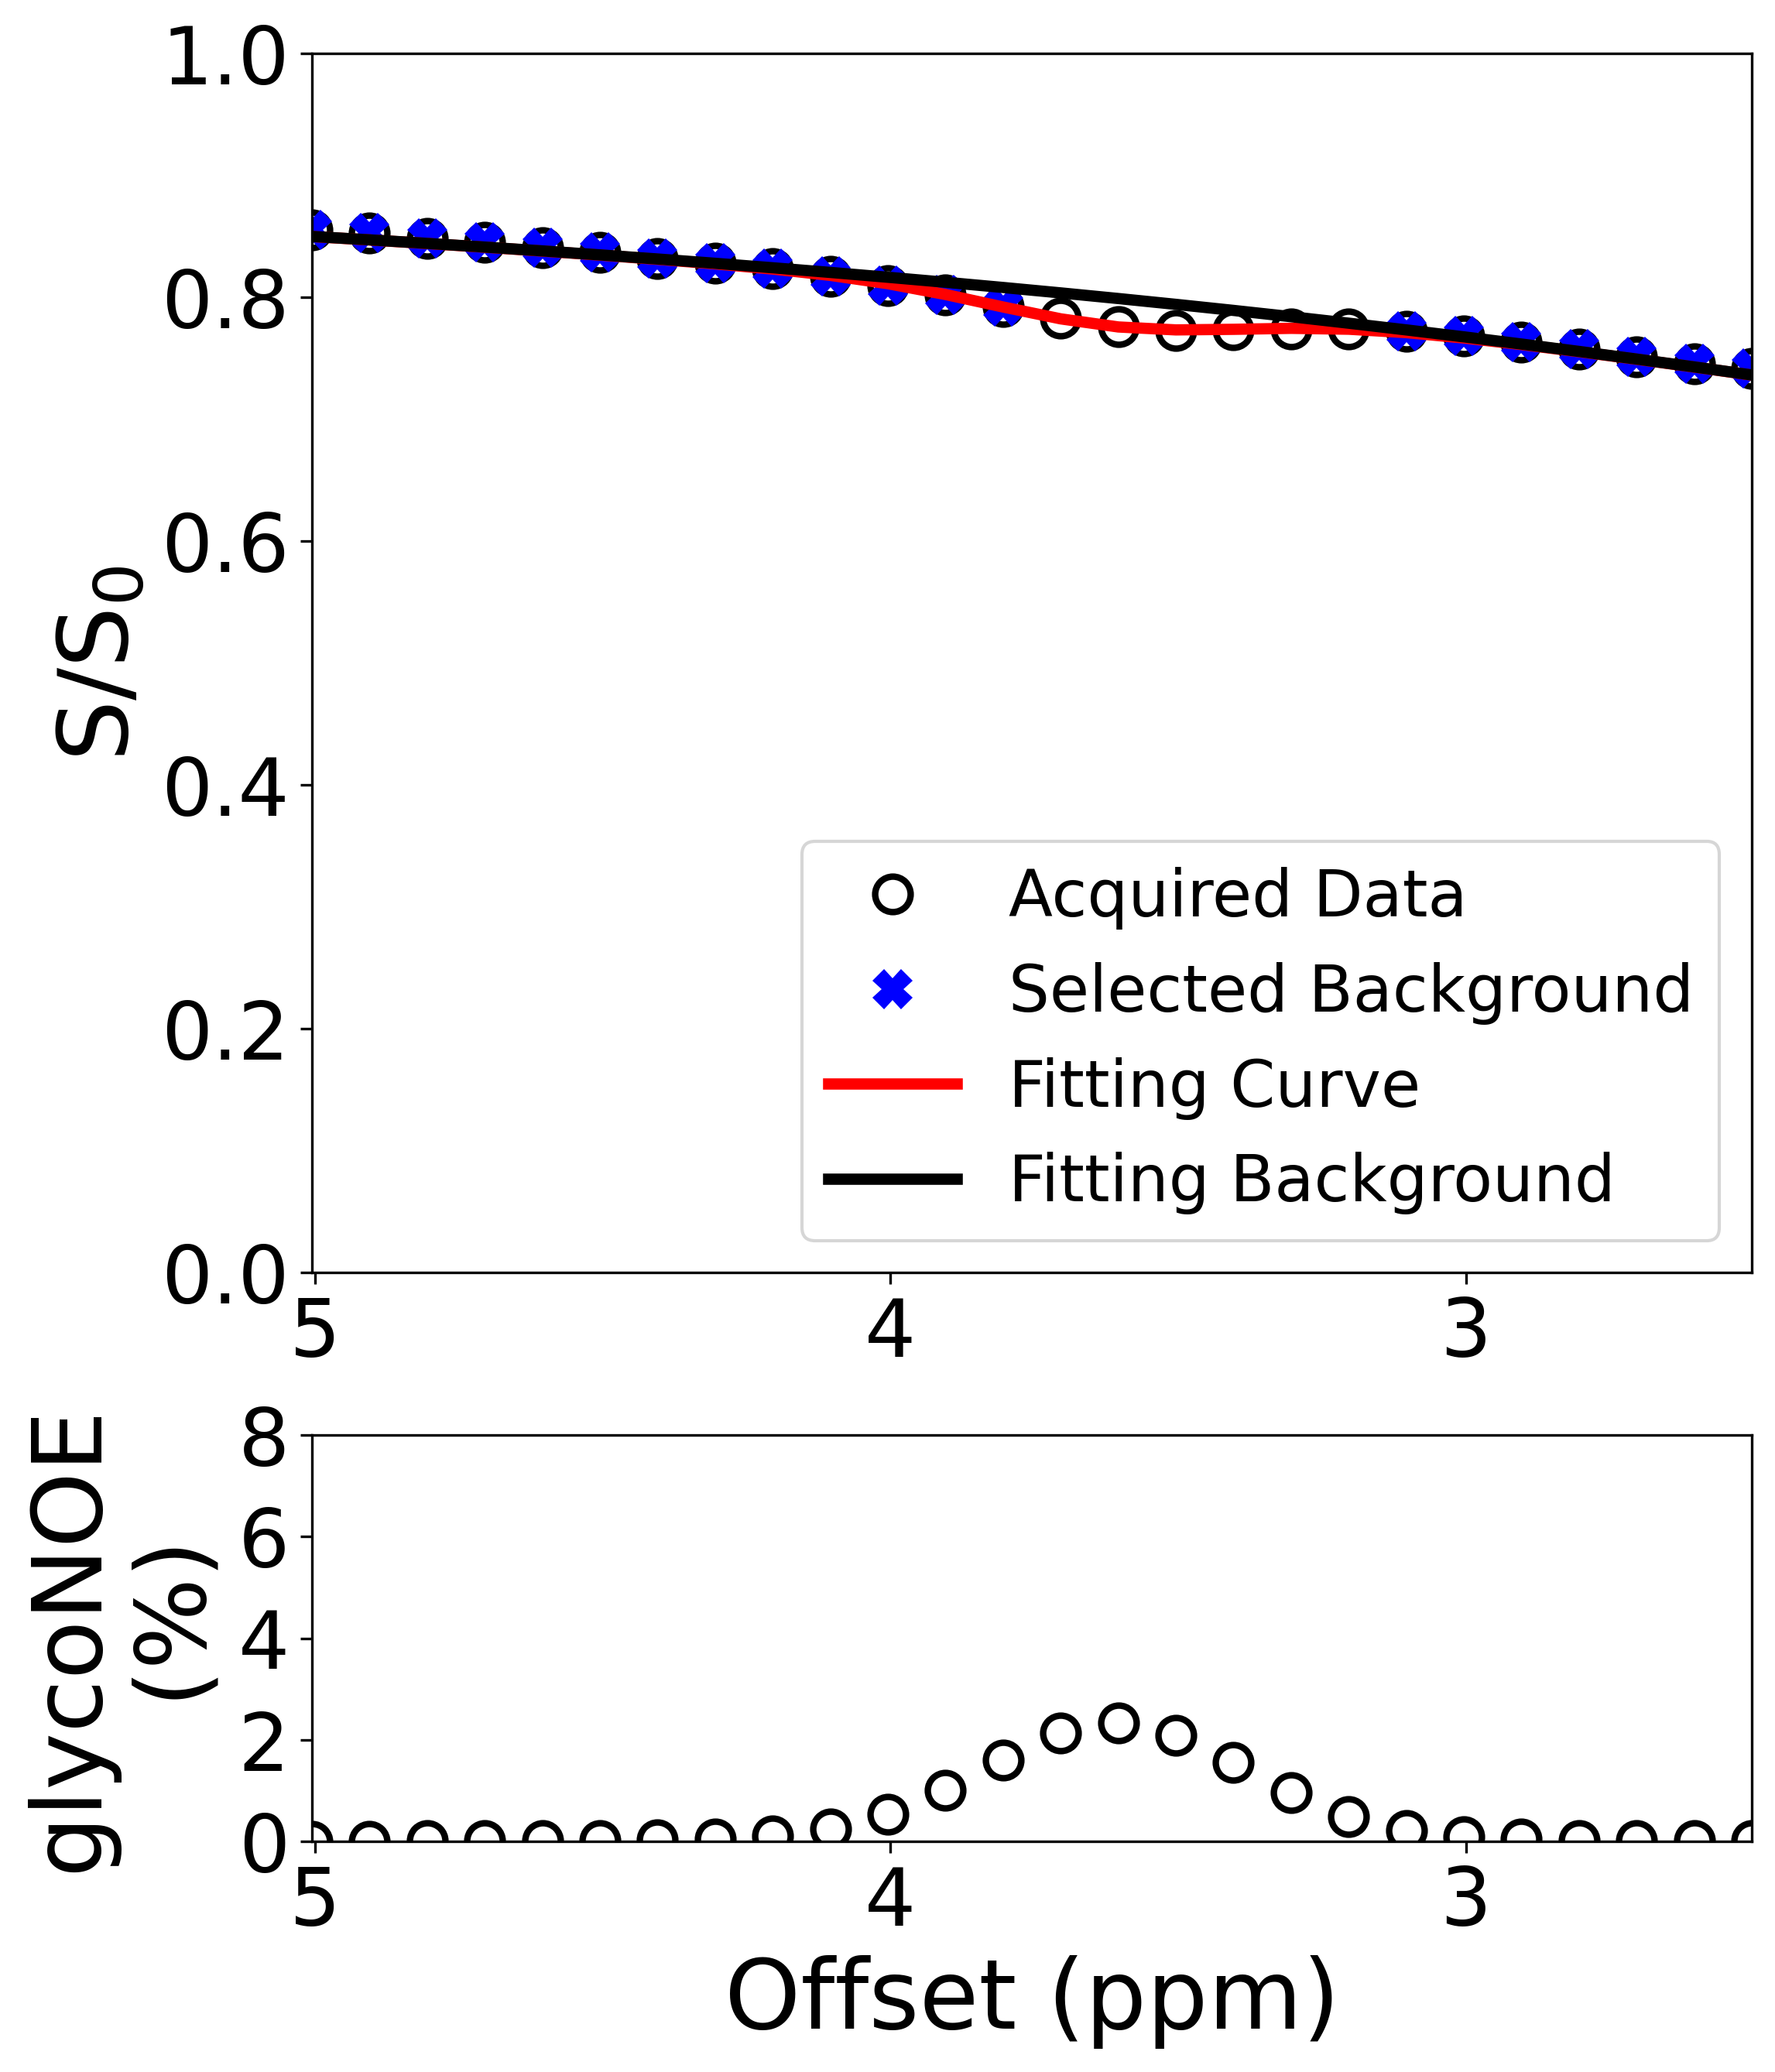

In [17]:
# try fitting downfield peaks with PLOF
import PLOF_fitting_voigt_peak_linear_back as PLOF_down

FitParam = {
 "WholeRange": r_[2.5, 5.0], 
 "PeakOffset": 3.5,
 "PeakRange": r_[3.2, 3.7],
 "Magfield": 42.58*11.7,
 "R1": [],
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":1
}

mask = mask_cest
intsTemp = np.ma.array(T1_map, mask=(mask==False))
T1 = intsTemp.mean()
FitParam["R1"] = 1/T1
Freq = cest_freq_norm
Z_spectrum = brain_ints
FitResults, FitParam = PLOF_down.PLOF(Freq,Z_spectrum,FitParam)
print('peak amplitude: %.3f' % FitResults["Rpeak"])
print('peak position: %.3f' % FitResults["FitPeakOffset"])
print('peak width: %.3f' % FitResults["PeakWidth"])
print('R: %.3f' % FitResults["R"])

peak amplitude: 0.026
peak position: 1.968
peak width: 0.481
R: 0.283


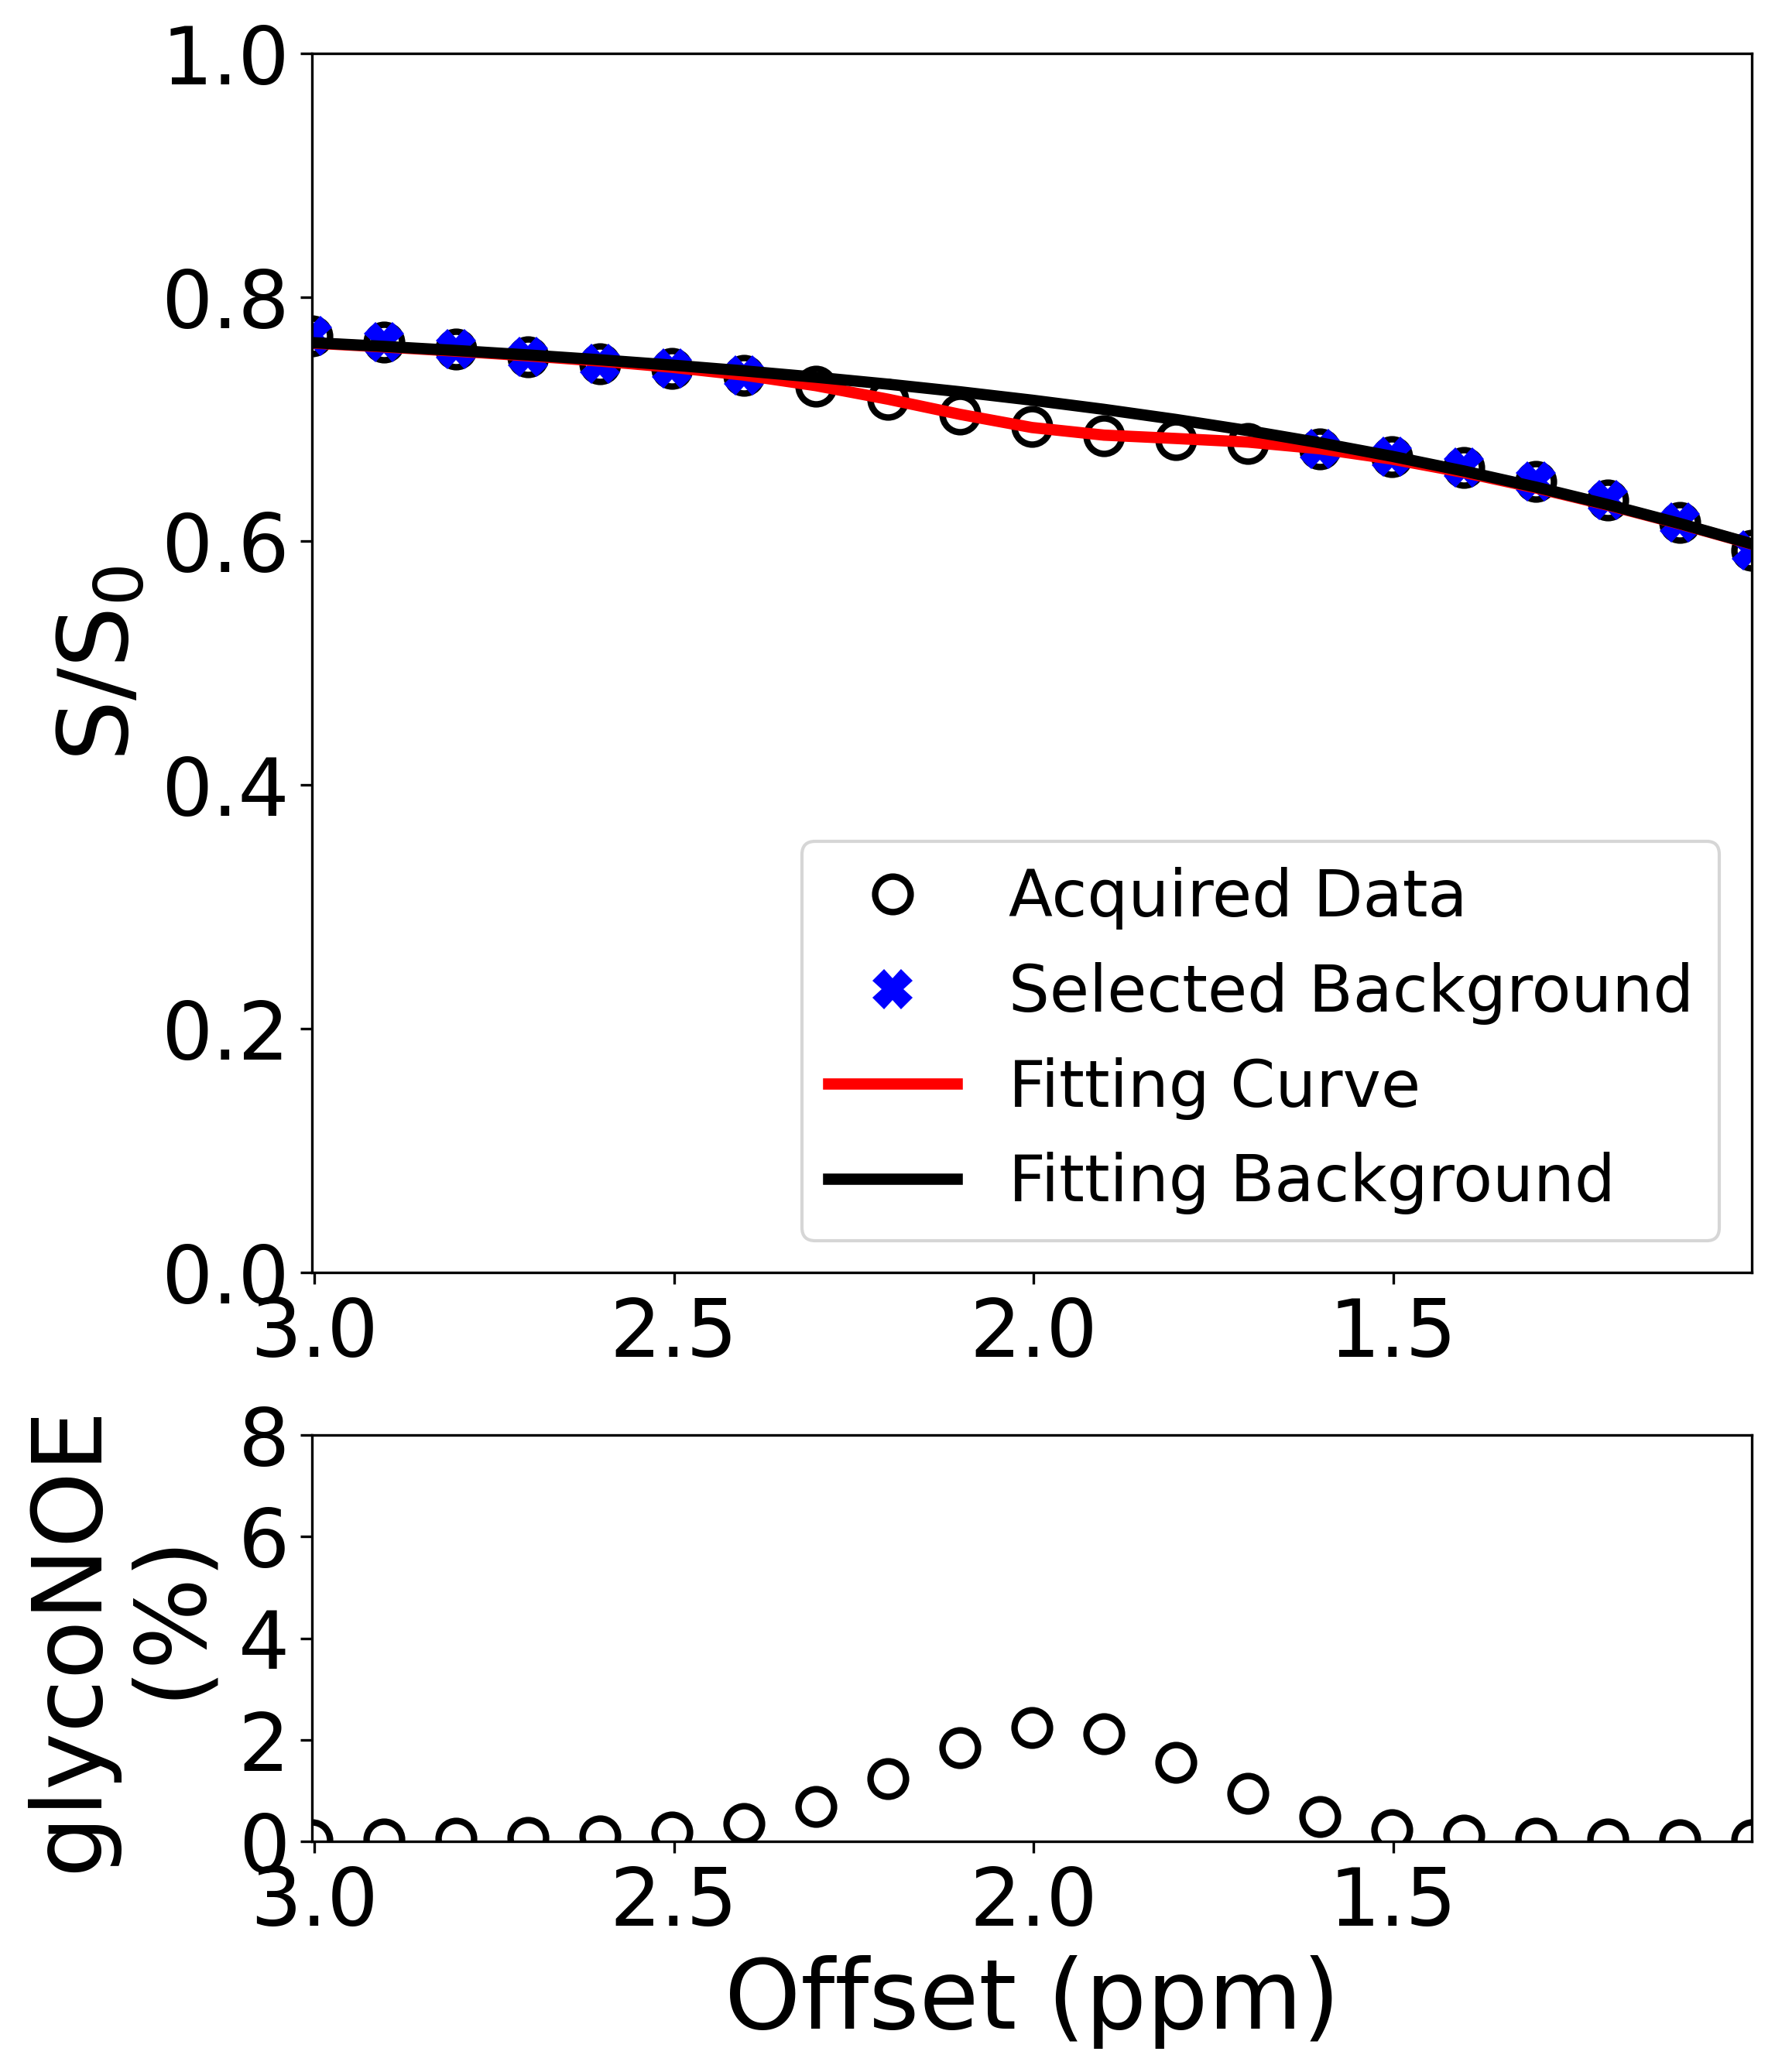

In [18]:
FitParam = {
 "WholeRange": r_[1.0, 3.0], 
 "PeakOffset": 2.,
 "PeakRange": r_[1.7, 2.3],
 "Magfield": 42.58*11.7,
 "R1": [],
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":1
}

mask = mask_cest
intsTemp = np.ma.array(T1_map, mask=(mask==False))
T1 = intsTemp.mean()
FitParam["R1"] = 1/T1
Freq = cest_freq_norm
Z_spectrum = brain_ints
FitResults, FitParam = PLOF_down.PLOF(Freq,Z_spectrum,FitParam)
print('peak amplitude: %.3f' % FitResults["Rpeak"])
print('peak position: %.3f' % FitResults["FitPeakOffset"])
print('peak width: %.3f' % FitResults["PeakWidth"])
print('R: %.3f' % FitResults["R"])

/home/yadav_lab/python_libs/PLOF_fitting_voigt.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0, 2, 4, 6, 8], fontsize= 25)


peak amplitude: 0.015
peak position: -0.978
peak width: 0.697
R: 0.000


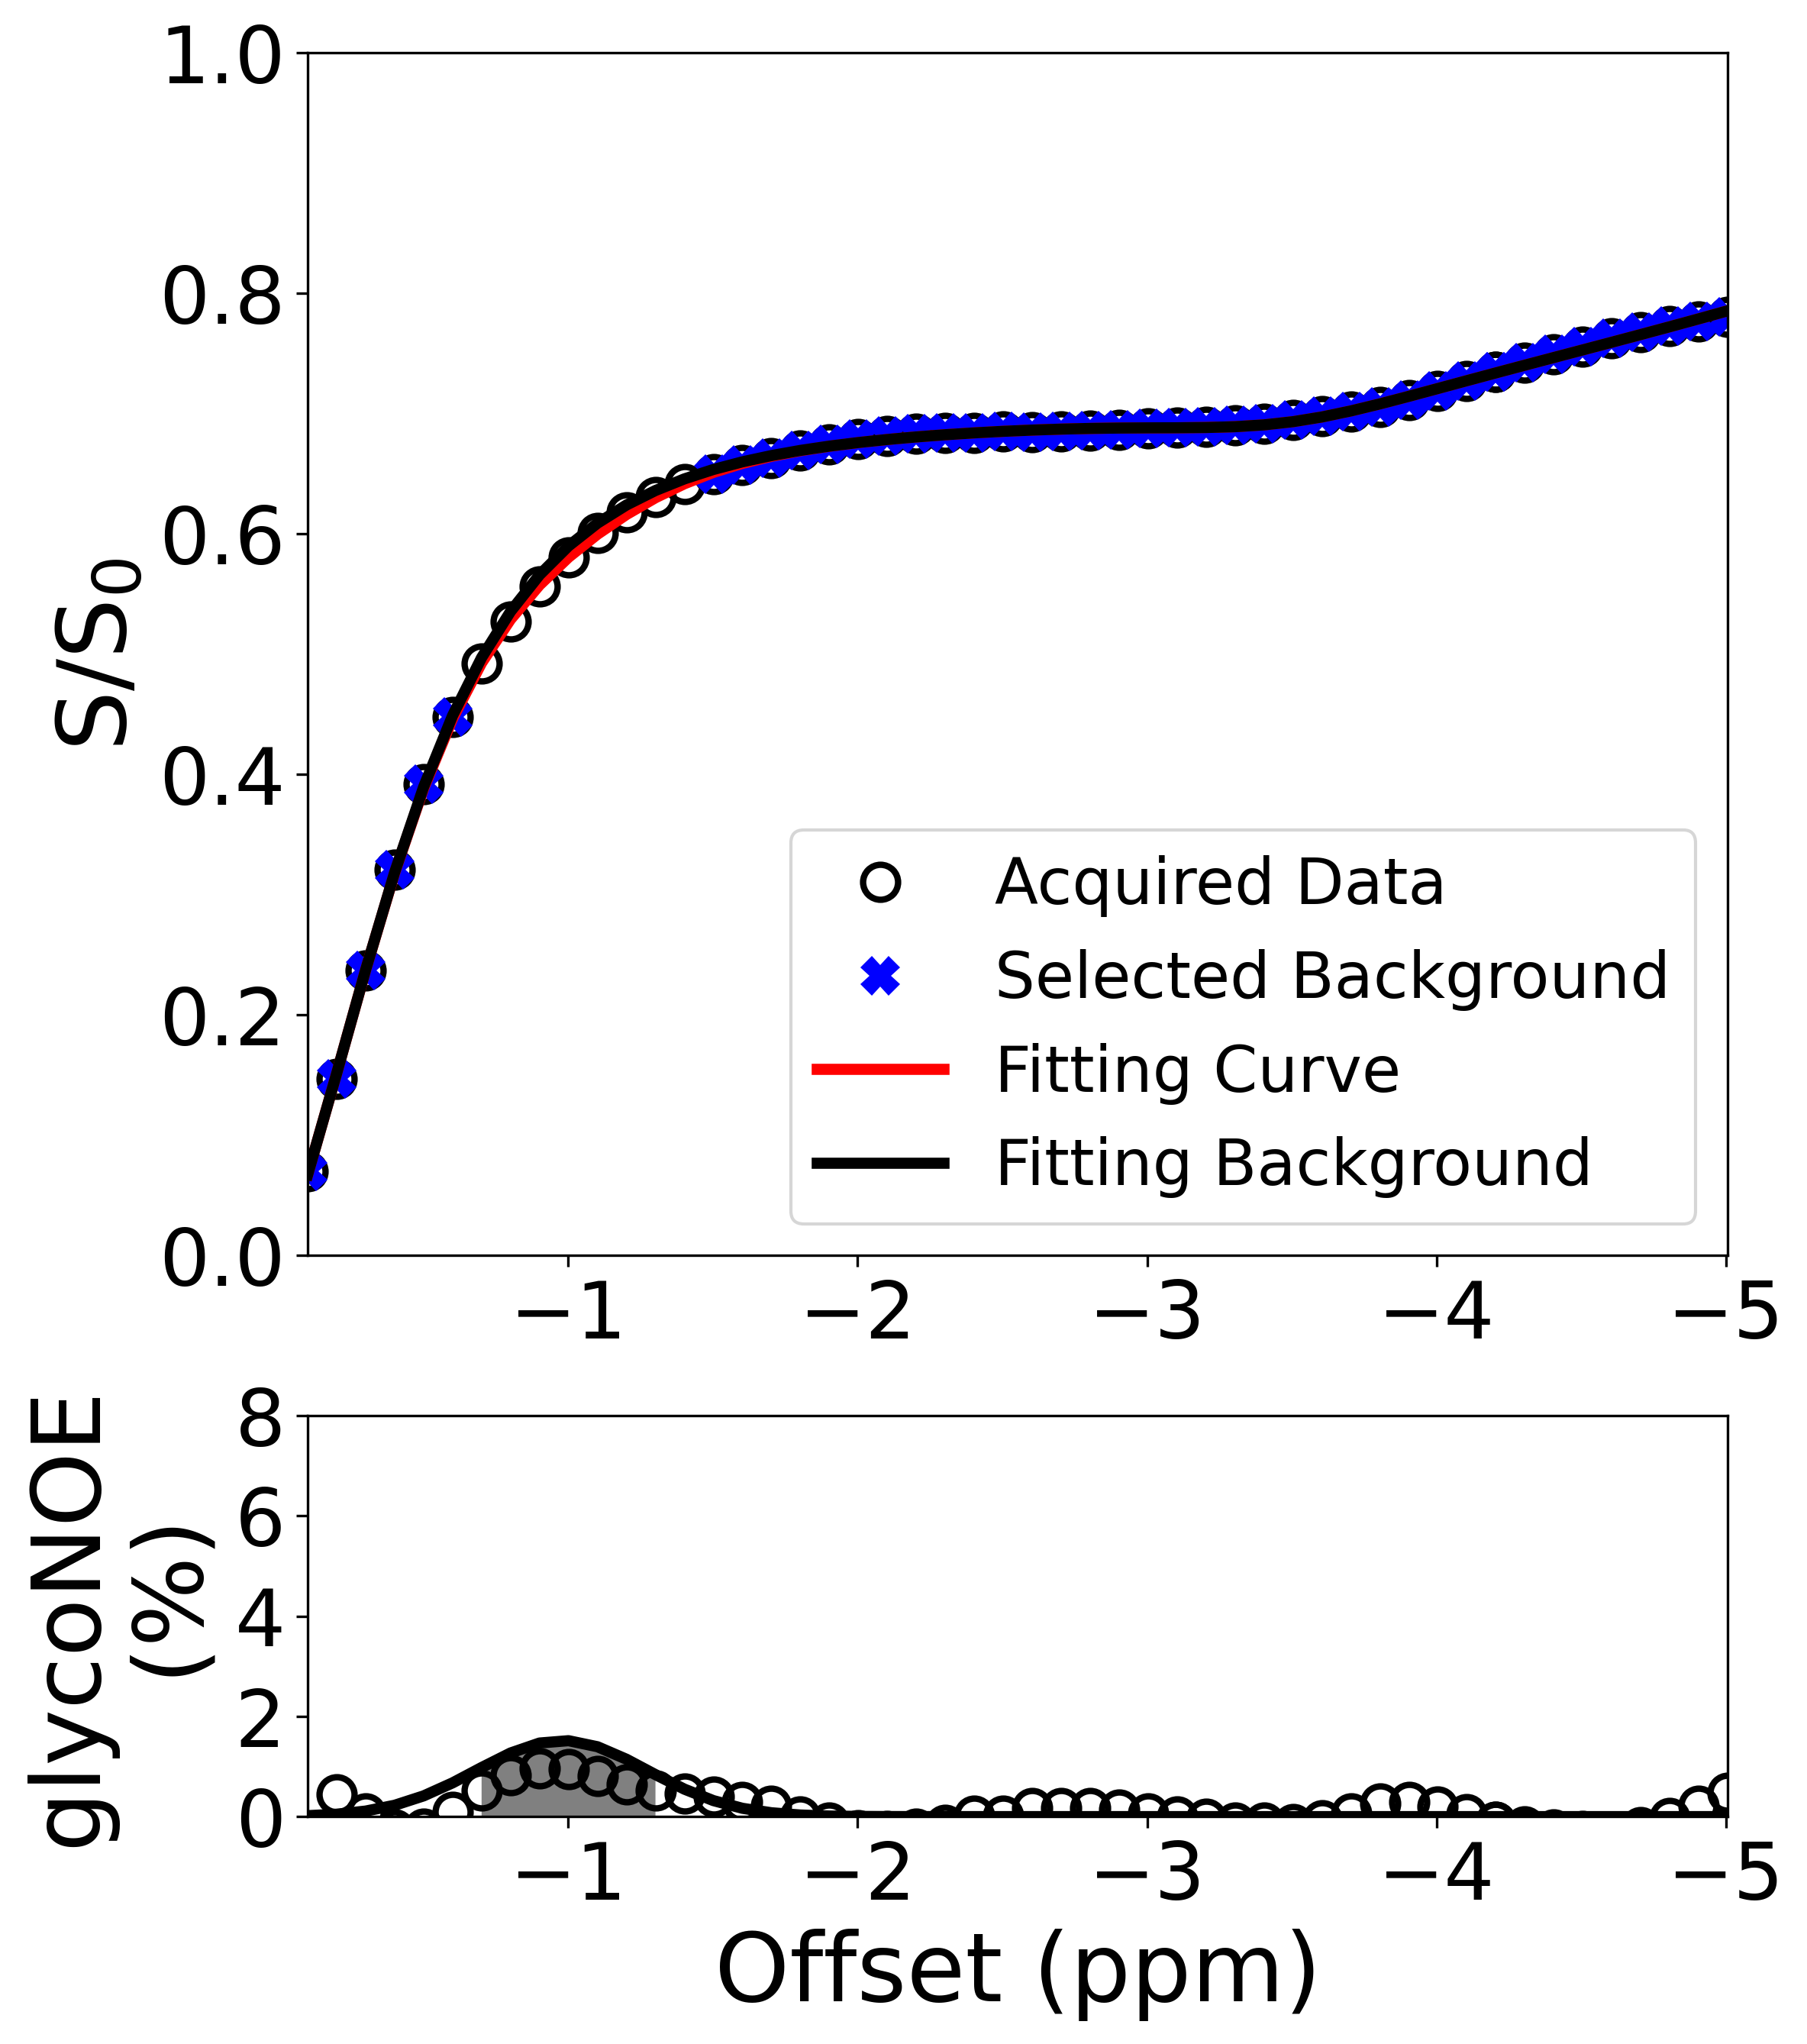

In [19]:
import PLOF_fitting_voigt as PLOF_up

FitParam = {
 "WholeRange": r_[-5, -0.1], 
 "PeakOffset": -1.,
 "PeakRange": r_[-1.4, -0.7],
 "Magfield": 42.58*11.7,
 "R1": [],
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":1
}

mask = mask_cest
intsTemp = np.ma.array(T1_map, mask=(mask==False))
T1 = intsTemp.mean()
FitParam["R1"] = 1/T1
Freq = cest_freq_norm
Z_spectrum = brain_ints
FitResults, FitParam = PLOF_up.PLOF(Freq,Z_spectrum,FitParam)
print('peak amplitude: %.3f' % FitResults["Rpeak"])
print('peak position: %.3f' % FitResults["FitPeakOffset"])
print('peak width: %.3f' % FitResults["PeakWidth"])
print('R: %.3f' % FitResults["R"])

peak amplitude: 0.013
peak position: -3.640
peak width: 0.462
R: 0.000


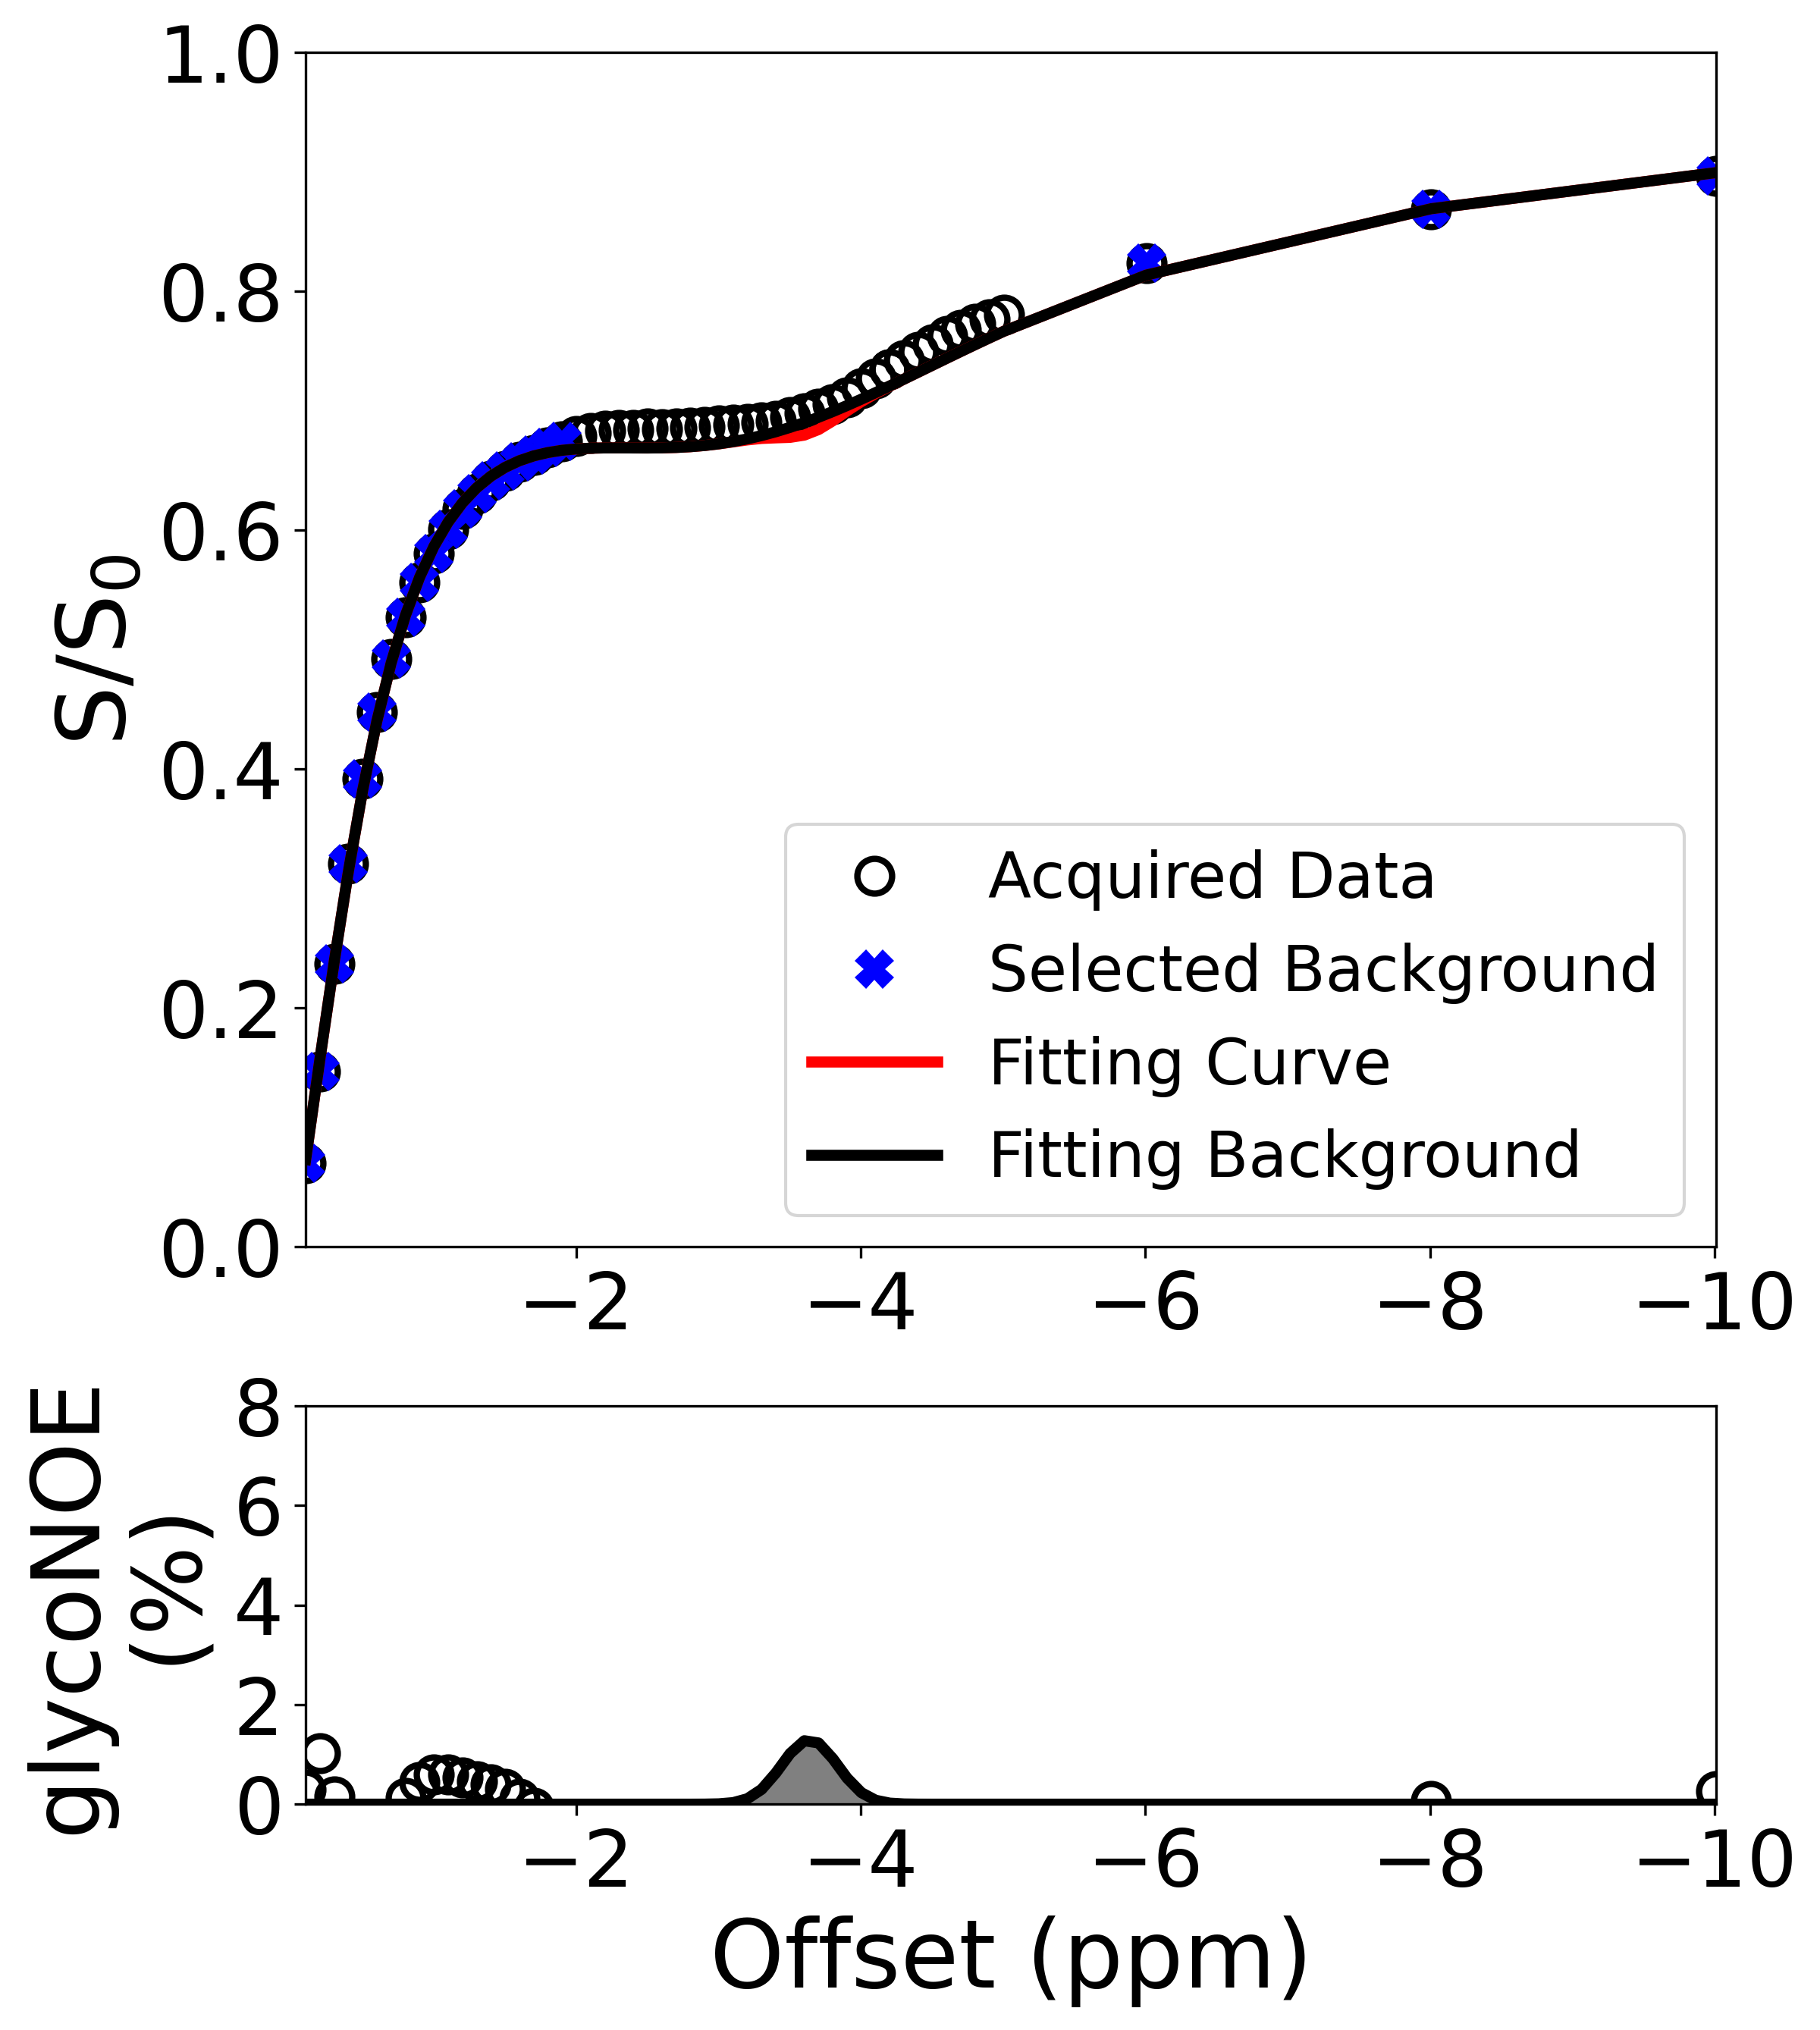

In [20]:
FitParam = {
 "WholeRange": r_[-10, -0.1], 
 "PeakOffset": -3.75,
 "PeakRange": r_[-5.0, -2.],
 "Magfield": 42.58*11.7,
 "R1": [],
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":1
}

mask = mask_cest
intsTemp = np.ma.array(T1_map, mask=(mask==False))
T1 = intsTemp.mean()
FitParam["R1"] = 1/T1
Freq = cest_freq_norm
Z_spectrum = brain_ints
FitResults, FitParam = PLOF_up.PLOF(Freq,Z_spectrum,FitParam)
print('peak amplitude: %.3f' % FitResults["Rpeak"])
print('peak position: %.3f' % FitResults["FitPeakOffset"])
print('peak width: %.3f' % FitResults["PeakWidth"])
print('R: %.3f' % FitResults["R"])

In [21]:
# map APT, creatine, and glycoNOE
import PLOF_fitting_voigt as PLOF_up

cest_data_corrected = np.load('%s/cest_data_corrected_s%s.npy'%(savePath, mouse_id))
cest_freq_norm = np.load('%s/cest_freq_norm_s%s.npy'%(savePath, mouse_id))
T1_map = np.load('%s/t1_map_s%s.npy'%(savePath, mouse_id))

FitParam_creatine = {
 "WholeRange": r_[1.0, 3.0], 
 "PeakOffset": 2.,
 "PeakRange": r_[1.7, 2.3],
 "Magfield": 42.58*11.7,
 "R1": [],
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":0
}

FitParam_apt = {
 "WholeRange": r_[2.3, 5.0], 
 "PeakOffset": 3.6,
 "PeakRange": r_[3.3, 3.8],
 "Magfield": 42.58*11.7,
 "R1": [],
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":0
}

FitParam_glycoNOE = {
 "WholeRange": r_[-2.5, -0.1], 
 "PeakOffset": -1.,
 "PeakRange": r_[-1.4, -0.7],
 "Magfield": 42.58*11.7,
 "R1": 1/1.5,
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":0
}

FitParam_rNOE = {
 "WholeRange": r_[-10, -0.1], 
 "PeakOffset": -3.75,
 "PeakRange": r_[-5.0, -2.],
 "Magfield": 42.58*11.7,
 "R1": [],
 "satpwr": 0.7,
 "tsat": 4,
 "ifshowimage":0
}


creatine_map = zeros((mask_cest.shape))
apt_map = zeros((mask_cest.shape))
glycoNOE_map = zeros((mask_cest.shape))
rNOE_map = zeros((mask_cest.shape))
for ix in range(mask_cest.shape[0]):
    print(ix)
    for iy in range(mask_cest.shape[1]):
        if (mask_cest[ix, iy] != 0):
            FitParam_creatine["R1"] = 1/T1_map[ix, iy]
            FitResults_creatine = PLOF_down.PLOF(cest_freq_norm,cest_data_corrected[:, ix, iy],FitParam_creatine)[0]
            creatine_map[ix, iy] = FitResults_creatine["Rpeak"]
            FitParam_apt["R1"] = 1/T1_map[ix, iy]
            FitResults_apt = PLOF_down.PLOF(cest_freq_norm,cest_data_corrected[:, ix, iy],FitParam_apt)[0]
            apt_map[ix, iy] = FitResults_apt["Rpeak"]
            FitParam_glycoNOE["R1"] = 1/T1_map[ix, iy]
            FitResults_glycoNOE = PLOF_up.PLOF(cest_freq_norm,cest_data_corrected[:, ix, iy],FitParam_glycoNOE)[0]
            glycoNOE_map[ix, iy] = FitResults_glycoNOE["DeltaZpeak"]
            FitParam_rNOE["R1"] = 1/T1_map[ix, iy]
            FitResults_rNOE = PLOF_up.PLOF(cest_freq_norm,cest_data_corrected[:, ix, iy],FitParam_rNOE)[0]
            rNOE_map[ix, iy] = FitResults_rNOE["Rpeak"]
            


np.save('%s/creatine_map_s%s.npy'%(savePath, mouse_id), creatine_map)
np.save('%s/apt_map.npy_s%s'%(savePath, mouse_id), apt_map)
np.save('%s/glycoNOE_map_s%s.npy'%(savePath, mouse_id), glycoNOE_map)
np.save('%s/rNOE_map_s%s.npy'%(savePath, mouse_id), glycoNOE_map)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


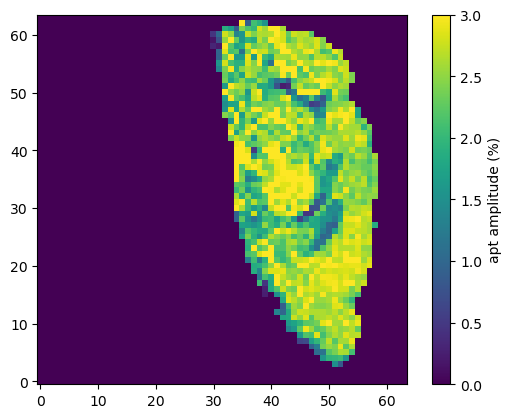

In [22]:
imshow(100*apt_map, origin='lower')
viridis()
clim(0, 3.0)
cbar = colorbar()
cbar.set_label('apt amplitude (%)')
savefig('%s/apt_map_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

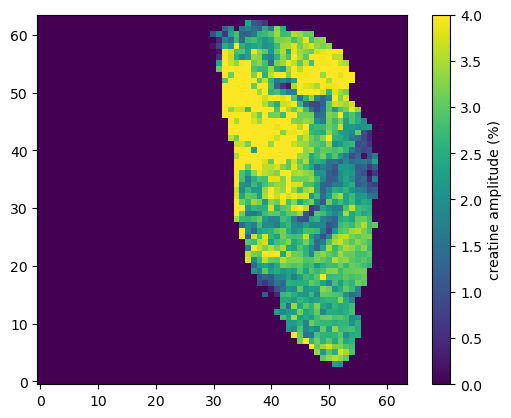

In [23]:
imshow(100*creatine_map, origin='lower')
viridis()
clim(0, 4.)
cbar = colorbar()
cbar.set_label('creatine amplitude (%)')
savefig('%s/creatine_map_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

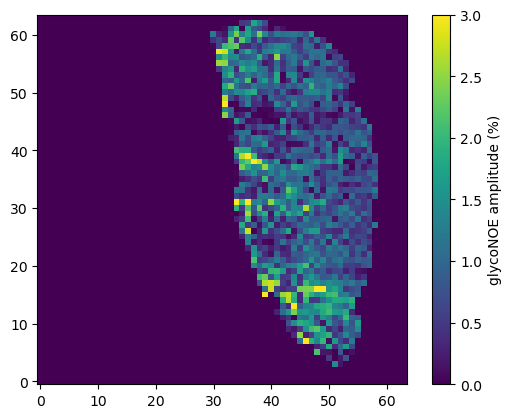

In [24]:
imshow(100*glycoNOE_map, origin='lower')
viridis()
clim(0, 3)
cbar = colorbar()
cbar.set_label('glycoNOE amplitude (%)')
savefig('%s/glycoNOE_map_s%s.png'%(savePath, mouse_id), bbox_inches='tight')

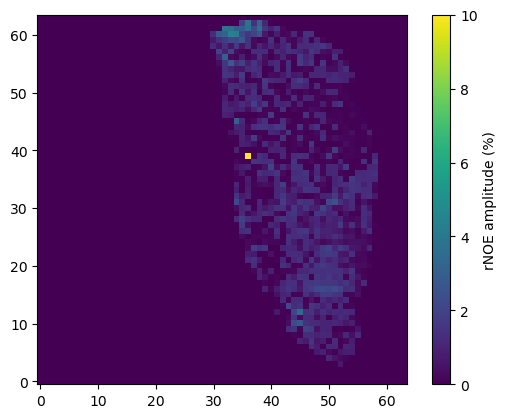

In [25]:
imshow(100*rNOE_map, origin='lower')
viridis()
clim(0, 10)
cbar = colorbar()
cbar.set_label('rNOE amplitude (%)')
savefig('%s/rNOE_map_s%s.png'%(savePath, mouse_id), bbox_inches='tight')